# Setting up the environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install chart_studio

In [3]:
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas.core import series
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import chart_studio as cs
import chart_studio.plotly as py
#import plotly.offline as py
#py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import time

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
cs.tools.set_credentials_file(username='manferra', api_key='1861dSyXqDzTS9ysHgkI')

In [5]:
# this function is needed to visualize plotly graph objects in colab and needs to be called in each cell where the library is used
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

# Average World Land Temperature

## 1. Line Graph

In [6]:
global_temp = pd.read_csv("/content/drive/MyDrive/GWCNAIModel_ClimateChangeEvolution/GlobalTemperatures.csv")
configure_plotly_browser_state()

#Extract the year from a date
years = np.unique(global_temp['dt'].apply(lambda x: x[:4]))
mean_temp_world = []
mean_temp_world_uncertainty = []

for year in years:
    mean_temp_world.append(global_temp[global_temp['dt'].apply(lambda x: x[:4]) == year]['LandAverageTemperature'].mean())
    mean_temp_world_uncertainty.append(global_temp[global_temp['dt'].apply(lambda x: x[:4]) == year]['LandAverageTemperatureUncertainty'].mean())

trace0 = go.Scatter(
    x = years, 
    y = np.array(mean_temp_world) + np.array(mean_temp_world_uncertainty),
    fill= None,
    mode='lines',
    name='Uncertainty top',
    line=dict(color='rgb(250, 99, 139)',)
)
trace1 = go.Scatter(
    x = years, 
    y = np.array(mean_temp_world) - np.array(mean_temp_world_uncertainty),
    fill='tonexty',
    mode='lines',
    name='Uncertainty bot',
    line=dict(color='rgb(250, 99, 139)',)
)
trace2 = go.Scatter(
    x = years, 
    y = mean_temp_world,
    name='Average Temperature',
    line=dict(color='rgb(0, 0, 0)',)
)

data = [trace0, trace1, trace2]

layout = go.Layout(
    xaxis=dict(title='year'),
    yaxis=dict(title='Average Temperature, °C'),
    title='Average land temperature in world',
    showlegend = False)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## 2. Making predictions with Time Series Forecasting

### Loading and Exploration of Data


In [7]:
# Create the pandas series
series = pd.Series(mean_temp_world, years)

# Print series info
# print(type(series))
print("FIRST 5 elements in series:")
print(series.head())
print("\nLAST 5 elements in series:")
print(series.tail())

FIRST 5 elements in series:
1750    8.719364
1751    7.976143
1752    5.779833
1753    8.388083
1754    8.469333
dtype: float64

LAST 5 elements in series:
2011    9.516000
2012    9.507333
2013    9.606500
2014    9.570667
2015    9.831000
dtype: float64


In [8]:
print(series.describe())

count    266.000000
mean       8.369337
std        0.584921
min        5.779833
25%        8.081563
50%        8.372167
75%        8.704167
max        9.831000
dtype: float64


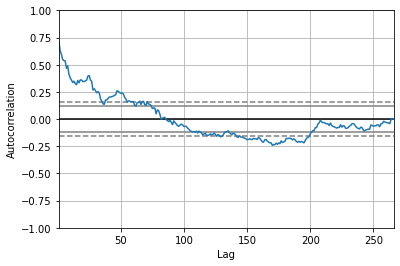

In [9]:
# autocorrelation plot
autocorrelation_plot(series, ax=None)

### Base Model - Persistance Algorithm

In [10]:
# Create lagged dataset
values = DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
print(dataframe.head(5))

          t       t+1
0       NaN  8.719364
1  8.719364  7.976143
2  7.976143  5.779833
3  5.779833  8.388083
4  8.388083  8.469333


In [11]:
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [12]:
# persistence model
def model_persistence(x):
  return x

# walk-forward validation
predictions = list()
for x in test_X:
  yhat = model_persistence(x)
  predictions.append(yhat)

rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.229


Line plot of the persistence forecast showing the training set (blue), test set (green) and predictions (orange).


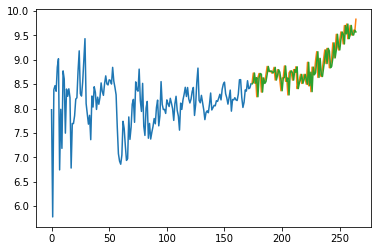

In [13]:
# plot predictions and expected results
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in predictions])
print("Line plot of the persistence forecast showing the training set (blue), test set (green) and predictions (orange).")

### Parameters Tuning and Model Training

In [14]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
  
  # prepare training dataset
  train_size = int(len(X) * 0.66)
  train, test = X[0:train_size], X[train_size:]
  history = [x for x in train]

  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])

  # calculate out-of-sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse

In [15]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
  dataset = dataset.astype('float32')
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        try:
          rmse = evaluate_arima_model(dataset, order)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
          print('ARIMA%s RMSE=%.3f' % (order,rmse))
        except:
          continue
  print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.746
ARIMA(0, 0, 1) RMSE=0.534
ARIMA(0, 0, 2) RMSE=0.456
ARIMA(0, 1, 0) RMSE=0.230
ARIMA(0, 1, 1) RMSE=0.183
ARIMA(0, 1, 2) RMSE=0.194
ARIMA(0, 2, 0) RMSE=0.398
ARIMA(0, 2, 1) RMSE=0.230
ARIMA(1, 0, 0) RMSE=0.346
ARIMA(1, 0, 1) RMSE=0.262
ARIMA(1, 1, 0) RMSE=0.201
ARIMA(1, 1, 1) RMSE=0.213
ARIMA(1, 2, 0) RMSE=0.286
ARIMA(2, 0, 0) RMSE=0.304
ARIMA(2, 0, 1) RMSE=0.250
ARIMA(2, 1, 0) RMSE=0.198
ARIMA(2, 1, 1) RMSE=0.215
ARIMA(2, 2, 0) RMSE=0.274
ARIMA(2, 2, 1) RMSE=0.199
ARIMA(4, 0, 0) RMSE=0.275
ARIMA(4, 0, 1) RMSE=0.249
ARIMA(4, 0, 2) RMSE=0.263
ARIMA(4, 1, 0) RMSE=0.198
ARIMA(4, 1, 1) RMSE=0.220
ARIMA(4, 1, 2) RMSE=0.218
ARIMA(4, 2, 0) RMSE=0.236
ARIMA(4, 2, 1) RMSE=0.197
ARIMA(6, 0, 0) RMSE=0.253
ARIMA(6, 0, 1) RMSE=0.254
ARIMA(6, 0, 2) RMSE=0.266
ARIMA(6, 1, 0) RMSE=0.195
ARIMA(6, 1, 1) RMSE=0.195
ARIMA(6, 1, 2) RMSE=0.219
ARIMA(6, 2, 0) RMSE=0.227
ARIMA(8, 0, 0) RMSE=0.253
ARIMA(8, 0, 1) RMSE=0.252
ARIMA(8, 0, 2) RMSE=0.257
ARIMA(8, 1, 0) RMSE=0.194
ARIMA(8, 1, 

### In-Sample Forecasting

In [61]:
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

Y = series.index
trainY, testY = Y[0:size], Y[size:len(Y)]

# walk-forward validation 
for t in range(len(test)):
  model = ARIMA(history, order=(0,1,1))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast()
  yhat = output[0][0]
  predictions.append(yhat)
  obs = test[t]
  history.append(obs)
  # print('predicted=%f, expected=%f' % (yhat, obs))

# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.183


In [17]:
trace_test = go.Scatter(
    x = testY, 
    y = test,
    name='Real Average Temperature',
    line=dict(color='rgb(0, 0, 0)',)
)
trace_forecast = go.Scatter(
    x = testY, 
    y = predictions,
    name='Predicted Average Temperature',
    line=dict(color='rgb(255, 0, 0)',)
)

data = [trace_test, trace_forecast]

layout = go.Layout(
    xaxis=dict(title='year'),
    yaxis=dict(title='Average Temperature, °C'),
    title='Average land temperature in world',
    showlegend = True)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [18]:
# summary of fit model
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  264
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -119.610
Method:                       css-mle   S.D. of innovations              0.380
Date:                Fri, 04 Mar 2022   AIC                            245.219
Time:                        13:16:29   BIC                            255.947
Sample:                             1   HQIC                           249.530
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.008      0.716      0.475      -0.010       0.022
ma.L1.D.y     -0.6488      0.060    -10.798      0.000      -0.767      -0.531
                                    Roots           

In [19]:
# summary stats of residual errors
residuals = DataFrame(model_fit.resid)
print(residuals.describe()) 

                0
count  264.000000
mean    -0.004570
std      0.385704
min     -2.544299
25%     -0.138897
50%      0.014401
75%      0.179699
max      1.134569


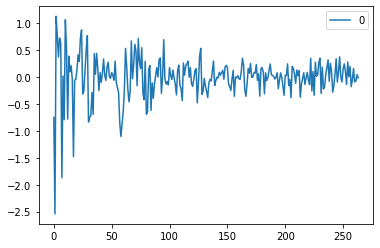

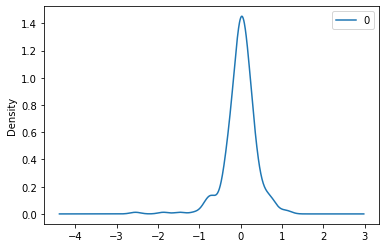

In [20]:
# line plot of the forecast residual errors
residuals.plot()

# density plot of residuals
residuals.plot(kind='kde')

### Out-of-Sample Forecasting

In [21]:
# create a differenced series
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return np.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

X = series.values
differenced = difference(X)
# fit model
model = ARIMA(differenced, order=(0,1,1))
model_fit = model.fit()
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=50)[0]

# invert the differenced forecast to something usable
history = [x for x in X]
day = 1
forecast_converted = list()
forecast_converted.append(X[len(X)-1])
print('Year 0: %f' % (X[len(X)-1]))
for yhat in forecast:
	inverted = inverse_difference(history, yhat, 1)
	print('Year %d: %f' % (day, inverted))
	history.append(inverted)
	forecast_converted.append(inverted)
	day += 1

Year 0: 9.831000
Year 1: 9.854976
Year 2: 9.879107
Year 3: 9.903393
Year 4: 9.927835
Year 5: 9.952432
Year 6: 9.977185
Year 7: 10.002093
Year 8: 10.027156
Year 9: 10.052375
Year 10: 10.077749
Year 11: 10.103278
Year 12: 10.128963
Year 13: 10.154803
Year 14: 10.180799
Year 15: 10.206950
Year 16: 10.233256
Year 17: 10.259718
Year 18: 10.286335
Year 19: 10.313108
Year 20: 10.340035
Year 21: 10.367119
Year 22: 10.394357
Year 23: 10.421751
Year 24: 10.449301
Year 25: 10.477005
Year 26: 10.504866
Year 27: 10.532881
Year 28: 10.561052
Year 29: 10.589378
Year 30: 10.617860
Year 31: 10.646497
Year 32: 10.675289
Year 33: 10.704237
Year 34: 10.733340
Year 35: 10.762599
Year 36: 10.792013
Year 37: 10.821582
Year 38: 10.851307
Year 39: 10.881187
Year 40: 10.911222
Year 41: 10.941413
Year 42: 10.971759
Year 43: 11.002261
Year 44: 11.032917
Year 45: 11.063730
Year 46: 11.094697
Year 47: 11.125821
Year 48: 11.157099
Year 49: 11.188533
Year 50: 11.220122


In [22]:
testy = list(testY)
predictiony = list()
for i in range(int(testy[len(testy)-1]), int(testy[len(testy)-1])+51):
  year = i
  predictiony.append(str(year))

trace_test = go.Scatter(
    x = testY, 
    y = test,
    name='Real Average Temperature',
    line=dict(color='rgb(0, 0, 0)',)
)
trace_forecast = go.Scatter(
    x = predictiony, 
    y = forecast_converted,
    name='Predicted Average Temperature',
    line=dict(color='rgb(255, 0, 0)',)
)

data = [trace_test, trace_forecast]

layout = go.Layout(
    xaxis=dict(title='year'),
    yaxis=dict(title='Average Temperature, °C'),
    title='Average land temperature in world',
    showlegend = True)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

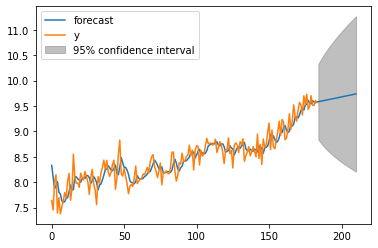

In [62]:
# plot some history and the forecast with confidence intervals
model_fit.plot_predict(len(test)-10, len(test)+200)
plt.legend(loc='upper left')
plt.show()

# Countries Average Temperatures

## 1. Globe Display

In [6]:
global_temp_country = pd.read_csv('/content/drive/MyDrive/GWCNAIModel_ClimateChangeEvolution/GlobalLandTemperaturesByCountry.csv')

#Let's remove the duplicated countries (in the analysis, we don't consider the presence of 
#colonies at this the countries) and countries for which no information about the temperature
global_temp_country_clear = global_temp_country[~global_temp_country['Country'].isin(
    ['Denmark', 'Antarctica', 'France', 'Europe', 'Netherlands',
     'United Kingdom', 'Africa', 'South America'])]

global_temp_country_clear = global_temp_country_clear.replace(
   ['Denmark (Europe)', 'France (Europe)', 'Netherlands (Europe)', 'United Kingdom (Europe)'],
   ['Denmark', 'France', 'Netherlands', 'United Kingdom'])

#Let's average temperature for each country
countries = np.unique(global_temp_country_clear['Country'])
mean_temp = []
for country in countries:
    mean_temp.append(global_temp_country_clear[global_temp_country_clear['Country'] == country]['AverageTemperature'].mean())

In [8]:
#Extract the year from a date
years = np.unique(global_temp_country_clear['dt'].apply(lambda x: x[:4]))

#Let's create an array and add the values of average temperatures in the countries every 10 years
mean_temp_year_country = [ [0] * len(countries) for i in range(len(years[::10]))]

j = 0
for country in countries:
    all_temp_country = global_temp_country_clear[global_temp_country_clear['Country'] == country]
    i = 0
    for year in years[::10]:
        mean_temp_year_country[i][j] = all_temp_country[all_temp_country['dt'].apply(
                lambda x: x[:4]) == year]['AverageTemperature'].mean()
        i +=1
    j += 1

In [11]:
#Let's create a Streaming in Plotly (here, alas, does not work, so commented out)

data = [ dict(
        type = 'choropleth',
        locations = countries,
        z = mean_temp,
        locationmode = 'country names',
        text = countries,
        marker = dict(
            line = dict(color = 'rgb(0,0,0)', width = 1)),
            colorbar = dict(tickprefix = '',
            title = '# Average\nTemperature,\n°C'),
            )
       ]
layout = dict(
    title = 'Average land temperature in countries',
    geo = dict(
        showframe = False,
        showocean = True,
        oceancolor = 'rgb(248,248,255)'
        # type = 'equirectangular'
    ),
)
configure_plotly_browser_state()
fig = dict(data=data, layout=layout)
py.iplot(fig)

## 2. Bar Graph

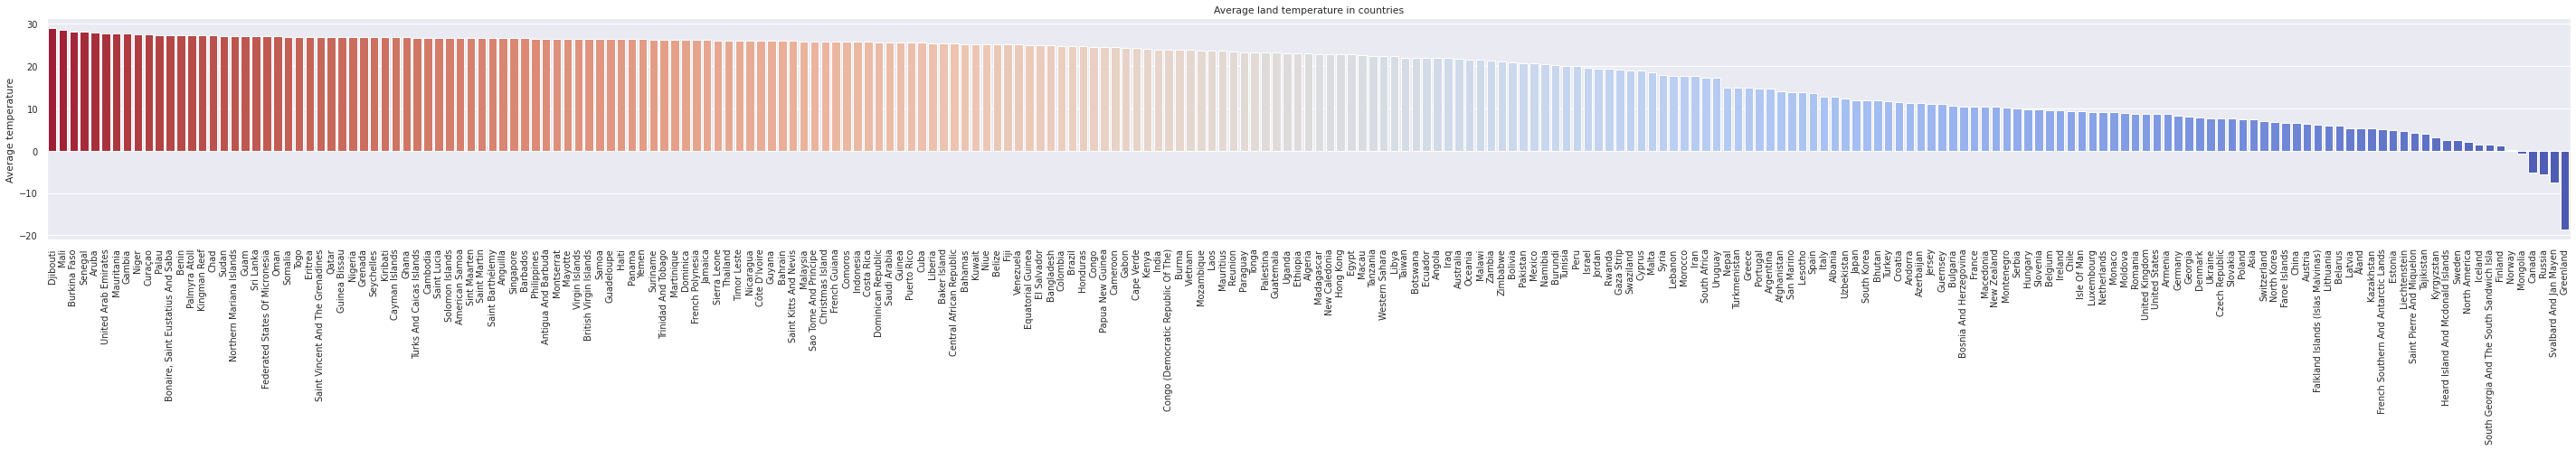

In [ ]:
mean_temp_bar, countries_bar = (list(x) for x in zip(*sorted(zip(mean_temp, countries), reverse = True)))
sns.set(font_scale=0.9) 
f, ax = plt.subplots(figsize=(50, 4.5))
plt.xticks(rotation=90)
colors_cw = sns.color_palette('coolwarm', len(countries))
sns.barplot(countries_bar, mean_temp_bar, palette = colors_cw[::-1])
Text = ax.set(ylabel='Average temperature', title='Average land temperature in countries')


## 3. Making predictions with Time Series Forecasting 

In [9]:
continent = ['Greenland', 'Canada', 'Italy', 'Australia', 'Mali']
mean_temp_year_country = [ [0] * len(years[70:]) for i in range(len(continent))]
j = 0
for country in continent:
    all_temp_country = global_temp_country_clear[global_temp_country_clear['Country'] == country]
    i = 0
    for year in years[70:]:
        mean_temp_year_country[j][i] = all_temp_country[all_temp_country['dt'].apply(
                lambda x: x[:4]) == year]['AverageTemperature'].mean()
        i +=1
    j += 1

traces = []
colors = ['rgb(48, 138, 228)', 'rgb(86, 171, 236)', 'rgb(255, 221, 62)',
          'rgb(242, 51, 59)', 'rgb(206, 8, 9)']
for i in range(len(continent)):
    traces.append(go.Scatter(
        x=years[70:],
        y=mean_temp_year_country[i],
        mode='lines',
        name=continent[i],
        line=dict(color=colors[i]),
    ))

layout = go.Layout(
    xaxis=dict(title='year'),
    yaxis=dict(title='Average Temperature, °C'),
    title='Average land temperature on the continents',)

configure_plotly_browser_state()
fig = go.Figure(data=traces, layout=layout)
py.iplot(fig)

In [12]:
# create a differenced series
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return np.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

### Greenland

In [76]:
greenland_temp = mean_temp_year_country[0]
greenland_series = pd.Series(greenland_temp, index=years[70:])
nan_elements = greenland_series.isnull()
greenland_series = greenland_series[~nan_elements]

# Print series info
# print(type(series))
print("FIRST 5 elements in series:")
print(greenland_series.head())
print("\nLAST 5 elements in series:")
print(greenland_series.tail())

FIRST 5 elements in series:
1823   -19.177667
1824   -18.692417
1825   -18.731000
1826   -18.649333
1827   -18.428333
dtype: float64

LAST 5 elements in series:
2009   -17.316417
2010   -15.546333
2011   -17.174333
2012   -16.772250
2013   -15.409750
dtype: float64


In [78]:
gX = greenland_series.values
differencedG = difference(gX)
# fit model
model = ARIMA(differencedG, order=(0,1,1))
model_fit = model.fit()
# multi-step out-of-sample forecast
greenland_forecast = model_fit.forecast(steps=50)[0]

# invert the differenced forecast to something usable
greenland_history = [x for x in gX]
day = 1
forecast_converted_greenland = list()
forecast_converted_greenland.append(gX[len(gX)-1])
print('Year 0: %f' % (gX[len(gX)-1]))

for yhat in greenland_forecast:
	invertedG = inverse_difference(greenland_history, yhat, 1)
	print('Year %d: %f' % (day, invertedG))
	greenland_history.append(invertedG)
	forecast_converted_greenland.append(invertedG)
	day += 1

Year 0: -15.409750
Year 1: -15.355660
Year 2: -15.301140
Year 3: -15.246190
Year 4: -15.190809
Year 5: -15.134997
Year 6: -15.078755
Year 7: -15.022083
Year 8: -14.964980
Year 9: -14.907447
Year 10: -14.849483
Year 11: -14.791089
Year 12: -14.732264
Year 13: -14.673009
Year 14: -14.613323
Year 15: -14.553207
Year 16: -14.492660
Year 17: -14.431683
Year 18: -14.370275
Year 19: -14.308437
Year 20: -14.246169
Year 21: -14.183470
Year 22: -14.120340
Year 23: -14.056780
Year 24: -13.992790
Year 25: -13.928369
Year 26: -13.863517
Year 27: -13.798236
Year 28: -13.732523
Year 29: -13.666380
Year 30: -13.599807
Year 31: -13.532803
Year 32: -13.465369
Year 33: -13.397504
Year 34: -13.329209
Year 35: -13.260484
Year 36: -13.191327
Year 37: -13.121741
Year 38: -13.051724
Year 39: -12.981276
Year 40: -12.910398
Year 41: -12.839090
Year 42: -12.767351
Year 43: -12.695181
Year 44: -12.622581
Year 45: -12.549551
Year 46: -12.476090
Year 47: -12.402199
Year 48: -12.327877
Year 49: -12.253125
Year 50: -

In [31]:
Y = years[70:]
predictionYears = list()
for i in range(int(Y[len(Y)-1]), int(Y[len(Y)-1])+51):
  year = i
  predictionYears.append(str(year)) 

In [80]:
trace_forecast_greenland = go.Scatter(
    x = predictionYears, 
    y = forecast_converted_greenland,
    name='Predicted Temperature',
    line=dict(color='rgb(255, 0, 0)',)
)

data_g = [traces[0]]
data_g.append(trace_forecast_greenland)

layout = go.Layout(
    xaxis=dict(title='year'),
    yaxis=dict(title='Average Temperature, °C'),
    title='Average land temperature in Greenland',
    showlegend = True)

fig = go.Figure(data=data_g, layout=layout)
py.iplot(fig)

### Canada

In [28]:
canada_temp = mean_temp_year_country[1]
canada_series = pd.Series(canada_temp, years[70:])
nan_elements = canada_series.isnull()
canada_series = canada_series[~nan_elements]

# Print series info
# print(type(series))
print("FIRST 5 elements in series:")
print(canada_series.head())
print("\nLAST 5 elements in series:")
print(canada_series.tail())

FIRST 5 elements in series:
1813    -3.395444
1814    -9.822667
1815    -6.409500
1816   -10.973625
1817    -6.629667
dtype: float64

LAST 5 elements in series:
2009   -4.135083
2010   -1.887917
2011   -3.557083
2012   -3.176833
2013   -1.640667
dtype: float64


In [29]:
cX = canada_series.values
differencedC = difference(cX)
# fit model
model = ARIMA(differencedC, order=(0,1,1))
model_fit = model.fit()
# multi-step out-of-sample forecast
canada_forecast = model_fit.forecast(steps=50)[0]

# invert the differenced forecast to something usable
canada_history = [x for x in cX]
day = 1
forecast_converted_canada = list()
forecast_converted_canada.append(cX[len(cX)-1])
print('Year 0: %f' % (cX[len(cX)-1]))

for yhat in canada_forecast:
	invertedC = inverse_difference(canada_history, yhat, 1)
	print('Year %d: %f' % (day, invertedC))
	canada_history.append(invertedC)
	forecast_converted_canada.append(invertedC)
	day += 1

Year 0: -1.640667
Year 1: -1.555216
Year 2: -1.468931
Year 3: -1.381812
Year 4: -1.293858
Year 5: -1.205069
Year 6: -1.115445
Year 7: -1.024987
Year 8: -0.933695
Year 9: -0.841567
Year 10: -0.748605
Year 11: -0.654809
Year 12: -0.560177
Year 13: -0.464712
Year 14: -0.368411
Year 15: -0.271276
Year 16: -0.173306
Year 17: -0.074502
Year 18: 0.025137
Year 19: 0.125611
Year 20: 0.226919
Year 21: 0.329062
Year 22: 0.432039
Year 23: 0.535852
Year 24: 0.640498
Year 25: 0.745980
Year 26: 0.852296
Year 27: 0.959446
Year 28: 1.067432
Year 29: 1.176252
Year 30: 1.285906
Year 31: 1.396395
Year 32: 1.507719
Year 33: 1.619877
Year 34: 1.732871
Year 35: 1.846698
Year 36: 1.961361
Year 37: 2.076857
Year 38: 2.193189
Year 39: 2.310355
Year 40: 2.428356
Year 41: 2.547191
Year 42: 2.666862
Year 43: 2.787366
Year 44: 2.908706
Year 45: 3.030879
Year 46: 3.153888
Year 47: 3.277731
Year 48: 3.402409
Year 49: 3.527922
Year 50: 3.654269


In [30]:
trace_forecast_canada = go.Scatter(
    x = predictionYears, 
    y = forecast_converted_canada,
    name='Predicted Temperature',
    line=dict(color='rgb(255, 0, 0)',)
)

data_c = [traces[1]]
data_c.append(trace_forecast_canada)

layout = go.Layout(
    xaxis=dict(title='year'),
    yaxis=dict(title='Average Temperature, °C'),
    title='Average land temperature in Canada',
    showlegend = True)

fig = go.Figure(data=data_c, layout=layout)
py.iplot(fig)

### Italy

In [14]:
italy_temp = mean_temp_year_country[2]
italy_series = pd.Series(italy_temp, years[70:])
nan_elements = italy_series.isnull()
italy_series = italy_series[~nan_elements]

# Print series info
# print(type(series))
print("FIRST 5 elements in series:")
print(italy_series.head())
print("\nLAST 5 elements in series:")
print(italy_series.tail())

FIRST 5 elements in series:
1813    12.113833
1814    11.514750
1815    12.118333
1816    11.301833
1817    12.310833
dtype: float64

LAST 5 elements in series:
2009    14.052917
2010    13.324917
2011    14.173167
2012    14.079000
2013    14.165000
dtype: float64


In [16]:
iX = italy_series.values
differencedI = difference(iX)
# fit model
model = ARIMA(differencedI, order=(0,1,1))
model_fit = model.fit()
# multi-step out-of-sample forecast
italy_forecast = model_fit.forecast(steps=50)[0]

# invert the differenced forecast to something usable
italy_history = [x for x in iX]
day = 1
forecast_converted_italy = list()
forecast_converted_italy.append(iX[len(iX)-1])
print('Year 0: %f' % (iX[len(iX)-1]))

for yhat in italy_forecast:
  invertedI = inverse_difference(italy_history, yhat, 1)
  print('Year %d: %f' % (day, invertedI))
  italy_history.append(invertedI)
  forecast_converted_italy.append(invertedI)
  day += 1

Year 0: 14.165000
Year 1: 14.186280
Year 2: 14.207673
Year 3: 14.229178
Year 4: 14.250797
Year 5: 14.272528
Year 6: 14.294373
Year 7: 14.316330
Year 8: 14.338400
Year 9: 14.360583
Year 10: 14.382879
Year 11: 14.405288
Year 12: 14.427810
Year 13: 14.450445
Year 14: 14.473193
Year 15: 14.496053
Year 16: 14.519027
Year 17: 14.542113
Year 18: 14.565312
Year 19: 14.588625
Year 20: 14.612050
Year 21: 14.635588
Year 22: 14.659239
Year 23: 14.683003
Year 24: 14.706879
Year 25: 14.730869
Year 26: 14.754972
Year 27: 14.779187
Year 28: 14.803516
Year 29: 14.827957
Year 30: 14.852511
Year 31: 14.877178
Year 32: 14.901958
Year 33: 14.926851
Year 34: 14.951857
Year 35: 14.976976
Year 36: 15.002208
Year 37: 15.027552
Year 38: 15.053010
Year 39: 15.078580
Year 40: 15.104263
Year 41: 15.130060
Year 42: 15.155969
Year 43: 15.181991
Year 44: 15.208126
Year 45: 15.234374
Year 46: 15.260734
Year 47: 15.287208
Year 48: 15.313795
Year 49: 15.340494
Year 50: 15.367307


In [19]:
trace_forecast_italy = go.Scatter(
    x = predictionYears, 
    y = forecast_converted_italy,
    name='Predicted Temperature',
    line=dict(color='rgb(255, 0, 0)',)
)

data_i = [traces[2]]
data_i.append(trace_forecast_italy)

layout = go.Layout(
    xaxis=dict(title='year'),
    yaxis=dict(title='Average Temperature, °C'),
    title='Average land temperature in Italy',
    showlegend = True)

fig = go.Figure(data=data_i, layout=layout)
py.iplot(fig)

### Australia

In [20]:
australia_temp = mean_temp_year_country[3]
australia_series = pd.Series(australia_temp, years[70:])
nan_elements = australia_series.isnull()
australia_series = australia_series[~nan_elements]

# Print series info
# print(type(series))
print("FIRST 5 elements in series:")
print(australia_series .head())
print("\nLAST 5 elements in series:")
print(australia_series.tail())

FIRST 5 elements in series:
1852    20.188500
1853    20.958250
1854    20.284778
1855    20.798636
1856    21.148333
dtype: float64

LAST 5 elements in series:
2009    22.690583
2010    22.078167
2011    21.767000
2012    22.024500
2013    22.142875
dtype: float64


In [21]:
aX = australia_series.values
differencedA = difference(aX)
# fit model
model = ARIMA(differencedA, order=(0,1,1))
model_fit = model.fit()
# multi-step out-of-sample forecast
australia_forecast = model_fit.forecast(steps=50)[0]

# invert the differenced forecast to something usable
australia_history = [x for x in aX]
day = 1
forecast_converted_australia = list()
forecast_converted_australia.append(aX[len(aX)-1])
print('Year 0: %f' % (aX[len(aX)-1]))

for yhat in australia_forecast:
	invertedA = inverse_difference(australia_history, yhat, 1)
	print('Year %d: %f' % (day, invertedA))
	australia_history.append(invertedA)
	forecast_converted_australia.append(invertedA)
	day += 1

Year 0: 22.142875
Year 1: 22.137150
Year 2: 22.131213
Year 3: 22.125065
Year 4: 22.118707
Year 5: 22.112137
Year 6: 22.105356
Year 7: 22.098364
Year 8: 22.091161
Year 9: 22.083747
Year 10: 22.076122
Year 11: 22.068286
Year 12: 22.060238
Year 13: 22.051980
Year 14: 22.043510
Year 15: 22.034830
Year 16: 22.025938
Year 17: 22.016835
Year 18: 22.007521
Year 19: 21.997997
Year 20: 21.988261
Year 21: 21.978313
Year 22: 21.968155
Year 23: 21.957786
Year 24: 21.947206
Year 25: 21.936414
Year 26: 21.925412
Year 27: 21.914198
Year 28: 21.902773
Year 29: 21.891138
Year 30: 21.879291
Year 31: 21.867233
Year 32: 21.854964
Year 33: 21.842484
Year 34: 21.829793
Year 35: 21.816891
Year 36: 21.803777
Year 37: 21.790453
Year 38: 21.776917
Year 39: 21.763171
Year 40: 21.749213
Year 41: 21.735044
Year 42: 21.720665
Year 43: 21.706074
Year 44: 21.691272
Year 45: 21.676259
Year 46: 21.661034
Year 47: 21.645599
Year 48: 21.629953
Year 49: 21.614095
Year 50: 21.598027


In [27]:
trace_forecast_australia = go.Scatter(
    x = predictionYears, 
    y = forecast_converted_australia,
    name='Predicted Temperature',
    line=dict(color='rgb(255, 0, 0)',)
)

data_a = [traces[3]]
data_a.append(trace_forecast_australia)

layout = go.Layout(
    xaxis=dict(title='year'),
    yaxis=dict(title='Average Temperature, °C'),
    title='Average land temperature in Australia',
    showlegend = True)

fig = go.Figure(data=data_a, layout=layout)
py.iplot(fig)

### Mali

In [23]:
mali_temp = mean_temp_year_country[4]
mali_series = pd.Series(mali_temp, years[70:])
nan_elements = mali_series.isnull()
mali_series = mali_series[~nan_elements]

# Print series info
# print(type(series))
print("FIRST 5 elements in series:")
print(mali_series.head())
print("\nLAST 5 elements in series:")
print(mali_series.tail())

FIRST 5 elements in series:
1849    27.916000
1850    27.957167
1851    28.201583
1856    27.821250
1857    27.928273
dtype: float64

LAST 5 elements in series:
2009    29.440917
2010    30.127083
2011    29.436667
2012    28.601833
2013    29.942000
dtype: float64


In [24]:
mX = mali_series.values
differencedM = difference(mX)
# fit model
model = ARIMA(differencedM, order=(0,1,1))
model_fit = model.fit()
# multi-step out-of-sample forecast
mali_forecast = model_fit.forecast(steps=50)[0]

# invert the differenced forecast to something usable
mali_history = [x for x in mX]
day = 1
forecast_converted_mali = list()
forecast_converted_mali.append(mX[len(mX)-1])
print('Year 0: %f' % (mX[len(mX)-1]))

for yhat in mali_forecast:
	invertedM = inverse_difference(mali_history, yhat, 1)
	print('Year %d: %f' % (day, invertedM))
	mali_history.append(invertedM)
	forecast_converted_mali.append(invertedM)
	day += 1

Year 0: 29.942000
Year 1: 29.965414
Year 2: 29.989067
Year 3: 30.012960
Year 4: 30.037092
Year 5: 30.061463
Year 6: 30.086073
Year 7: 30.110922
Year 8: 30.136011
Year 9: 30.161339
Year 10: 30.186906
Year 11: 30.212712
Year 12: 30.238758
Year 13: 30.265042
Year 14: 30.291566
Year 15: 30.318329
Year 16: 30.345332
Year 17: 30.372573
Year 18: 30.400054
Year 19: 30.427774
Year 20: 30.455733
Year 21: 30.483932
Year 22: 30.512369
Year 23: 30.541046
Year 24: 30.569962
Year 25: 30.599118
Year 26: 30.628512
Year 27: 30.658146
Year 28: 30.688019
Year 29: 30.718131
Year 30: 30.748482
Year 31: 30.779073
Year 32: 30.809903
Year 33: 30.840972
Year 34: 30.872280
Year 35: 30.903828
Year 36: 30.935614
Year 37: 30.967640
Year 38: 30.999905
Year 39: 31.032410
Year 40: 31.065153
Year 41: 31.098136
Year 42: 31.131358
Year 43: 31.164819
Year 44: 31.198520
Year 45: 31.232459
Year 46: 31.266638
Year 47: 31.301056
Year 48: 31.335714
Year 49: 31.370610
Year 50: 31.405746


In [26]:
trace_forecast_mali = go.Scatter(
    x = predictionYears, 
    y = forecast_converted_mali,
    name='Predicted Temperature',
    line=dict(color='rgb(255, 0, 0)',)
)

data_m = [traces[4]]
data_m.append(trace_forecast_mali)

layout = go.Layout(
    xaxis=dict(title='year'),
    yaxis=dict(title='Average Temperature, °C'),
    title='Average land temperature in Mali',
    showlegend = True)

fig = go.Figure(data=data_m, layout=layout)
py.iplot(fig)

# Sources 

[1]   Earth, B. (2017, May 1). Climate change: Earth surface temperature data. Kaggle. Retrieved March 2, 2022, from https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByCity.csv 

[2]   Brownlee, J. (2017). Introduction to time series forecasting with python: How to prepare data and develop models to predict the future. Jason Brownlee. 

[3]    Sadrach, P. (2021, October 6). A guide to time series forecasting in Python. Built In. Retrieved March 2, 2022, from https://builtin.com/data-science/time-series-forecasting-python 

[4]   Peixeiro, M. (2022, February 2). The Complete Guide to Time Series Analysis and forecasting. Medium. Retrieved March 2, 2022, from https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775 

[5]   Amelin, V. (2016, November 11). Map of temperatures and analysis of global warming. Kaggle. Retrieved March 2, 2022, from https://www.kaggle.com/amelinvladislav/map-of-temperatures-and-analysis-of-global-warming  

